# **Group 19 APS360 Project: Emojification 😀**

# Emotion Recognition CNN

## Settings

In [ ]:
# turn off to disable CUDA
use_cuda = True
train_again = False

## Imports

In [ ]:
# LIBRARY IMPORTS #
import numpy as np
from PIL import Image
import pandas as pd
import time
import csv
import random
import matplotlib.pyplot as plt
import os
import random

# TORCH IMPORTS #
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [ ]:
# make a folder called APS360 in your drive that matches the below paths
# and then run this code to mount your drive and unzip the files
from google.colab import drive
drive.mount('/content/drive')

if os.path.exists("/content/NPU-FER"):
  print(".zip folders already unzipped.")
else:
  !unzip "/content/drive/MyDrive/APS360/Project/NPU-FER.zip" -d "/content" &> /dev/null
  !unzip "/content/drive/MyDrive/APS360/Project/NewFERPLus.zip" -d "/content" &> /dev/null
  !unzip "/content/drive/MyDrive/APS360/Project/Emoji-Regular.zip" -d "/content" &> /dev/null
  !unzip "/content/drive/MyDrive/APS360/Project/Emoji-BW-48x48-CULLED.zip" -d "/content" &> /dev/null
  !unzip "/content/drive/MyDrive/APS360/Project/happy_interp.zip" -d "/content" &> /dev/null

Mounted at /content/drive


## Data Cleaning and Data Loaders

In [ ]:
import os
import glob
from PIL import Image, ImageFilter

def add_gaussian_noise(image_path):
    original_image = Image.open(image_path)
    noisy_image = original_image.filter(ImageFilter.GaussianBlur(radius=2))
    return noisy_image

def rotate_image(image_path):
    original_image = Image.open(image_path)
    rotated_image = original_image.rotate(90)
    return rotated_image

def process_pngs(dir_path):
    png_files = glob.glob(os.path.join(dir_path, '*.png'))
    for png_file in png_files:
        # Add gaussian noise to the image
        noisy_image = add_gaussian_noise(png_file)
        noisy_image.save(png_file[:-4] + '_gaussian.png')

        # Rotate the image by 90 degrees
        rotated_image = rotate_image(png_file)
        rotated_image.save(png_file[:-4] + '_rotated.png')

def process_bmps(dir_path):
    bmp_files = glob.glob(os.path.join(dir_path, '*.bmp'))
    for bmp_file in bmp_files:
        # Add gaussian noise to the image
        noisy_image = add_gaussian_noise(bmp_file)
        noisy_image = noisy_image.convert('RGB')
        noisy_image.save(bmp_file[:-4] + '_gaussian.bmp')

        # Rotate the image by 90 degrees
        rotated_image = rotate_image(bmp_file)
        rotated_image = rotated_image.convert('RGB')
        rotated_image.save(bmp_file[:-4] + '_rotated.bmp')

def process_png_directory(path):
  classes = ["disgust", "angry", "fear", "happy", "sadness", "surprise"]
  for i in classes:
    process_pngs(path + i)

def process_bmp_directory(path):
  classes = ["disgust", "angry", "fear", "happy", "sadness", "surprise"]
  for i in classes:
    process_bmps(path + i)

In [ ]:
# running this actually seems to decrease accuracy so I commented it out
process_bmp_directory("/content/NPU-FER/")
process_png_directory("/content/NewFERPLus/")

In [ ]:
def get_relevant_indices(dataset, classes, target_classes, num_per_class):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    class_counts = {cls: 0 for cls in target_classes}
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1]
        label_class = classes[label_index]
        #we want to make sure it stops appending indices once the desired number of images per class is reached
        if label_class in target_classes and class_counts[label_class] < num_per_class:
            indices.append(i)
            class_counts[label_class] += 1
    return indices

def rotate_imgs(img):
    angle = random.choice([1, 2, 3])
    return torch.rot90(img, k=angle, dims=(1,2))

def get_data_loader(target_classes):
    classes = ('angry', 'disgust', 'fear', 'happy', 'sadness', 'surprise')

    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1]. To make sure
    # all images are consistent, we transform them into 48*48 grayscale
    # images.
    transform = transforms.Compose(
        [transforms.Resize((48, 48)),
         transforms.Grayscale(),
         transforms.ToTensor(),
         transforms.Normalize((0.5,), (0.5,))])
    # Load training data from folder
    data_orig_1 = torchvision.datasets.ImageFolder(root='/content/NPU-FER', transform=transform)
    data_orig_2 = torchvision.datasets.ImageFolder(root='/content/NewFERPLus', transform=transform)
    data_total = torch.utils.data.ConcatDataset([data_orig_1, data_orig_2])
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(data_total, classes, target_classes, num_per_class = 350)

    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split_val = int(len(relevant_indices) * 0.7) #split at 70%
    split_test = int(len(relevant_indices) * (0.7 + 0.15)) #split again at 85%

    # split into training and validation indices
    relevant_train_indices, relevant_val_indices, relevant_test_indices = relevant_indices[:split_val], \
                    relevant_indices[split_val:split_test], relevant_indices[split_test:]

    trainset = torch.utils.data.Subset(data_total, relevant_train_indices)
    valset = torch.utils.data.Subset(data_total, relevant_val_indices)
    testset = torch.utils.data.Subset(data_total, relevant_test_indices)

    # augmentation of trainset
    #transform_rotate = transforms.Compose([transforms.Lambda(rotate_imgs)])
    #train_copy = torch.utils.data.Subset(data_total, relevant_train_indices)
    #train_copy.dataset.transform = transform_rotate

    # putting modified data with unmodified data
    #trainset = torch.utils.data.ConcatDataset([train_copy, trainset])

    return trainset, valset, testset

In [ ]:
# this loads the three sets into easily-accessible variables
trainset, valset, testset = get_data_loader(target_classes=['angry',
                          'disgust', 'fear', 'happy', 'sadness', 'surprise'])

In [ ]:
print("Train: " + str(len(trainset)))
print("Validation: " + str(len(valset)))
print("Test: " + str(len(testset)))

Train: 1470
Validation: 315
Test: 315


In [ ]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64)

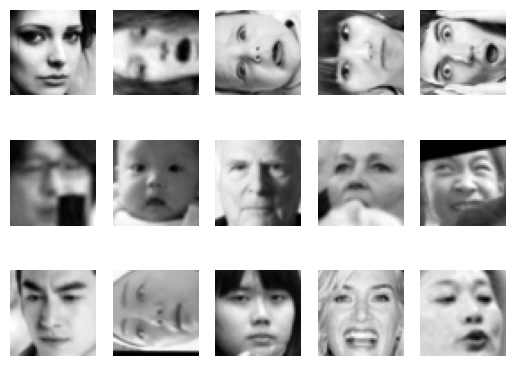

In [ ]:
# just a test that a few pictures can be printed

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img,cmap='gray')

    k += 1
    if k > 14:
        break

## Convolutional Neural Network

In [ ]:
# function to plot training curves
def plot_curve(iters, train_acc, train_loss, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
# defining our NNs and their respective training functions

# the facial emotion recognition CNN
# input image = 48x48?
class CNN_FER(nn.Module):
    def __init__(self):
        super(CNN_FER, self).__init__()
        self.name = "fer"
        self.conv1 = nn.Conv2d(1, 6, 5) # in_channel, out_channel, kernel_size
        self.pool = nn.MaxPool2d(2, 2) # kernel_size, stride
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(9 * 9 * 12, 64)
        self.fc2 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 9 * 9 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:

        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)

        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

def train_classifier(model, train_loader, val_loader, batch_size=64, learning_rate=0.01, momentum=0.9, num_epochs=5):
  torch.manual_seed(1)
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), learning_rate, momentum)

  iters, train_acc, train_loss, val_acc = [], [], [], []

  # training
  n = 0 # the number of iterations
  for epoch in range(num_epochs):

      total_train_loss = 0.0
      for imgs, labels in iter(train_loader):

          #############################################
          #To Enable GPU Usage
          if use_cuda and torch.cuda.is_available():
            imgs = imgs.cuda()
            labels = labels.cuda()
          #############################################

          out = model(imgs)             # forward pass

          loss = criterion(out, labels) # compute the total loss
          loss.backward()               # backward pass (compute parameter updates)
          optimizer.step()              # make the updates for each parameter
          optimizer.zero_grad()         # a clean up step for PyTorch
          total_train_loss += loss.item()

      # save the current training information
      iters.append(n)
      train_loss.append(total_train_loss / (len(train_loader) * batch_size))             # compute *average* loss
      train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy
      val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
      n += 1

      # report acc and loss after every epoch
      print(("Epoch {}: Train acc: {}, Train loss: {} | "+
          "Val acc: {}").format(
              epoch + 1,
              train_acc[epoch],
              train_loss[epoch],
              val_acc[epoch]))

  plot_curve(iters, train_acc, train_loss, val_acc)
  # save checkpoints or plot curve

In [ ]:
# training our fer_net
# instantiating NNs
torch.manual_seed(1)
fer_net = CNN_FER()

if use_cuda and torch.cuda.is_available():
  fer_net.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

if train_again:
  # proper model
  train_classifier(fer_net, train_loader, val_loader, learning_rate=0.05, num_epochs=20)

CUDA is available!  Training on GPU ...


In [ ]:
print("TEST ACCURACY: ", get_accuracy(fer_net, test_loader))

TEST ACCURACY:  0.6222222222222222


In [ ]:
# torch.save(fer_net.state_dict(), "model_cnn_62")

In [ ]:
# for loading the model state
!cp "/content/drive/MyDrive/APS360/Project/model_cnn_62" -d "/content" &> /dev/null

fer_net = CNN_FER()
if use_cuda and torch.cuda.is_available():
  fer_net.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

fer_net.load_state_dict(torch.load("model_cnn_62"))

CUDA is available!  Training on GPU ...


<All keys matched successfully>

In [ ]:
# code to test an individual image
test_data = testset[0] # change this to choose which image

test_label = test_data[1]
test_img = test_data[0]

print("label: ", test_label)

#############################################
#To Enable GPU Usage
if use_cuda and torch.cuda.is_available():
  test_img = test_img.cuda()
#############################################

pred = fer_net(test_img)
print(pred)

predicted_label = torch.argmax(pred, dim=1)
print("predicted: ", predicted_label.item())

#just printing an easier-to-read output statement
if (test_label == predicted_label):
  print("PASS")
else:
  print("FAIL")

label:  3
tensor([[-6.6808,  3.2539, -5.5865,  9.6273, -0.8957,  2.6299]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
predicted:  3
PASS


# VAE

## Imports

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn.functional as F
import time

## Settings

In [4]:
# SETTINGS

# Shuffle
DO_SHUFFLE = True

# Data paths
dataset_path_human = '/content/Small_Celeba_Files_2'

dataset_path_emoji = '/content/content/25k_emojis_6'

# Hyperparameters
RANDOM_SEED = 0
LEARNING_RATE = 0.002
BATCH_SIZE = 256
NUM_EPOCHS = 50

# Model Parameters
latent_dim = 200

In [5]:
#Set all random seeds.
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

## Dataset

In [6]:
# Dataset

class ImageDataset(Dataset):
  def __init__(self, directory, transform=None):
    self.directory = directory
    self.transform = transform
    self.image_files = os.listdir(directory)

  def __len__(self):
    return len(self.image_files)

  def __getitem__(self, idx):
    image_path = os.path.join(self.directory, self.image_files[idx])
    image = Image.open(image_path).convert('L')
    if self.transform:
      image = self.transform(image)
    return image

transform = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

from google.colab import drive
drive.mount('/content/drive')

if os.path.exists("/content/Small_Celeba_Files_2") and os.path.exists("/content/content/25k_emojis_6"):
  print(".zip folders already unzipped.")
else:
  !unzip "/content/drive/MyDrive/APS360/Project/Small_Celeba_Files_2.zip" -d "/content" &> /dev/null
  !unzip "/content/drive/MyDrive/APS360/Project/25k_emojis_6.zip" -d "/content" &> /dev/null


dataset_human = ImageDataset(dataset_path_human, transform=transform)

dataset_emoji = ImageDataset(dataset_path_emoji, transform=transform)

total_set = torch.utils.data.ConcatDataset([dataset_human,
                                            dataset_emoji])

total_size = len(total_set)
train_size = int(0.7 * total_size)
test_size = int(0.15 * total_size)
val_size = total_size - train_size - test_size

train_set, test_set, val_set = torch.utils.data.random_split(total_set, [train_size, test_size, val_size])

train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=DO_SHUFFLE, drop_last=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=DO_SHUFFLE, drop_last=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=DO_SHUFFLE, drop_last=True)

Mounted at /content/drive


In [7]:
print("train_loader size: " + str(len(train_loader.dataset)))
print("test_loader size: " + str(len(test_loader.dataset)))
print("val_loader size: " + str(len(val_loader.dataset)))

train_loader size: 159310
test_loader size: 34138
val_loader size: 34139


## Model

In [8]:
# MODEL

class Do_View(nn.Module):
  def __init__(self, *args):
    super().__init__()
    self.shape = args
  def forward(self, x):
    return x.view(self.shape)

class Cut_Down(nn.Module):
  def __init__(self, *args):
    super().__init__()
  def forward(self, x):
    return x[:,:, :48, :48]

class VAE_Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
      nn.Conv2d(1, 32, stride=2, kernel_size=3, bias=False, padding=1),
      nn.BatchNorm2d(32),
      nn.LeakyReLU(0.1, inplace=True),
      nn.Dropout2d(0.25),
      # Now size 24x24x32
      nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.1, inplace=True),
      nn.Dropout2d(0.25),
      # Now size is 12x12x64
      nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.1, inplace=True),
      nn.Dropout2d(0.25),
      # Now size is 6x6x64
      nn.Flatten(),
      #Now total length is 6x6x64=2304
    )

    self.z_mean = torch.nn.Linear(2304, 200)
    self.z_log_var = torch.nn.Linear(2304, 200)

    self.decoder = nn.Sequential(
        torch.nn.Linear(200,2304),
        Do_View(-1,64,6,6),
        #Now size is 6x6x64
        nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Dropout2d(0.25),
        #Now size is 13x13x64
        nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Dropout2d(0.25),
        #Now size is 25x25x32
        nn.ConvTranspose2d(32, 1, stride=2, kernel_size=3, padding=1),
        #Now size is 49x49x1
        Cut_Down(), #1x49x49 -> 1x48x48
        nn.Sigmoid()
    )

  def encoding_fn(self, x):
    x = self.encoder(x)
    z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
    encoded = self.reparameterize(z_mean, z_log_var)
    return encoded

  def reparameterize(self, z_mu, z_log_var):
    eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
    z = z_mu + eps * torch.exp(z_log_var/2.)
    return z

  def forward(self, x):
    x = self.encoder(x)
    z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
    encoded = self.reparameterize(z_mean, z_log_var)
    decoded = self.decoder(encoded)
    return encoded, z_mean, z_log_var, decoded

  def decoding(self, x):
    decoded = self.decoder(x)
    return decoded


In [9]:
vae_model = VAE_Model()
vae_model.cuda()
optimizer = torch.optim.Adam(vae_model.parameters(), lr=LEARNING_RATE)

## Training

In [10]:
def train_vae(num_epochs, model, optimizer, train_loader, save_location, val_loader, reconstruction_term_weight=1):

  start_time = time.time() #Start time for entire training loop

  batch_loss = []
  train_loss = []
  val_loss = []

  loss_fn = F.mse_loss #Define loss function

  #Start of epoch loop
  for epoch in range(num_epochs):

    epoch_start_time = time.time()

    print("Start of epoch " + str(epoch))

    model.train() #Set training mode, which is different than eval mode.

    for i, image in enumerate(train_loader):

      image = image.cuda() #Need to set this so that it works with CUDA support.

      encoded, z_mean, z_log_var, decoded = model(image)

      kl_div = -0.5 * torch.sum(1 + z_log_var
                                - z_mean**2
                                - torch.exp(z_log_var),
                                axis=1) #Standard equation for VAE model
      batchsize = kl_div.size(0) #More VAE analysis
      kl_div = kl_div.mean()

      pixelwise_loss = loss_fn(decoded, image, reduction='none') #Get the loss across the batch
      pixelwise_loss = pixelwise_loss.view(batchsize, -1).sum(axis=1) #View it as a single row
      pixelwise_loss = pixelwise_loss.mean() #Take the mean across all pixels

      loss = reconstruction_term_weight*pixelwise_loss + kl_div

      optimizer.zero_grad() #Zero out the gradients before performing backwards step

      loss.backward() #Compute gradients

      optimizer.step() #Move according to the gradients.

      batch_loss.append(loss.item())
      print("Epoch " + str(epoch) + ", Batch " + str(i) + ", Batch Loss: " + str(loss.item()))

    model.eval() #Set eval mode

    #Compute loss across all test images here:
    loss_total = 0
    for i, image in enumerate(train_loader):
      image = image.cuda()

      encoded, z_mean, z_log_var, decoded = model(image)

      kl_div = -0.5 * torch.sum(1 + z_log_var
                                - z_mean**2
                                - torch.exp(z_log_var),
                                axis=1) #Standard equation for VAE model
      batchsize = kl_div.size(0) #More VAE analysis
      kl_div = kl_div.mean()

      pixelwise_loss = loss_fn(decoded, image, reduction='none') #Get the loss across the batch
      pixelwise_loss = pixelwise_loss.view(batchsize, -1).sum(axis=1) #View it as a single row
      pixelwise_loss = pixelwise_loss.mean() #Take the mean across all pixels

      loss = reconstruction_term_weight*pixelwise_loss + kl_div

      loss_total = loss_total + loss.item()
    train_loss.append(loss_total / (i+1))

    #Compute loss across all validation imagaes here:
    loss_total = 0
    for i, image in enumerate(val_loader):
      image = image.cuda()

      encoded, z_mean, z_log_var, decoded = model(image)

      kl_div = -0.5 * torch.sum(1 + z_log_var
                                - z_mean**2
                                - torch.exp(z_log_var),
                                axis=1) #Standard equation for VAE model
      batchsize = kl_div.size(0) #More VAE analysis
      kl_div = kl_div.mean()

      pixelwise_loss = loss_fn(decoded, image, reduction='none') #Get the loss across the batch
      pixelwise_loss = pixelwise_loss.view(batchsize, -1).sum(axis=1) #View it as a single row
      pixelwise_loss = pixelwise_loss.mean() #Take the mean across all pixels

      loss = reconstruction_term_weight*pixelwise_loss + kl_div

      loss_total = loss_total + loss.item()
    val_loss.append(loss_total / (i+1))

    epoch_end_time = time.time()
    print("End of epoch " + str(epoch) + ". Total elapsed time: " + str(epoch_end_time - epoch_start_time) + "s. Train loss: " + str(train_loss[epoch]) + ". Validation loss: " + str(val_loss[epoch]) + ".")



  torch.save(model.state_dict(), save_location) #Save the model

  end_time = time.time() #End time for entire training loop
  print("Total elapsed time: " + str(end_time - start_time) + "s")

  return batch_loss, train_loss, val_loss

In [ ]:
batch_loss, train_loss, val_loss = train_vae(num_epochs=NUM_EPOCHS, model=vae_model, optimizer=optimizer,
                            train_loader=train_loader, val_loader=val_loader, save_location='vae_test.pt')

KeyboardInterrupt: ignored

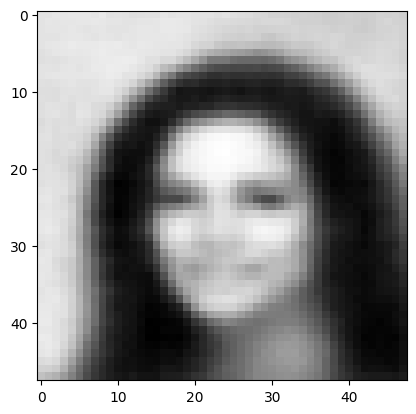

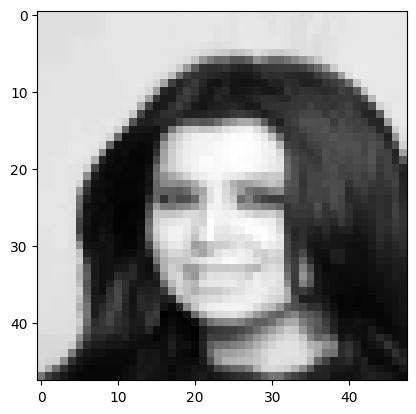

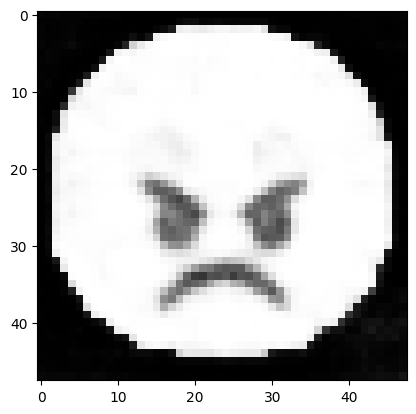

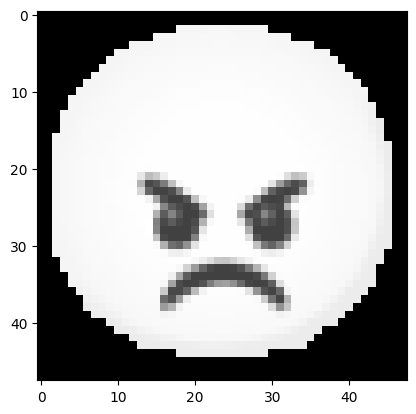

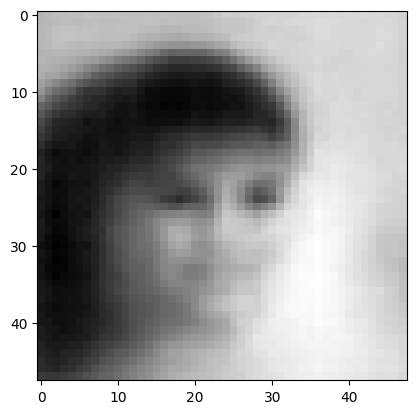

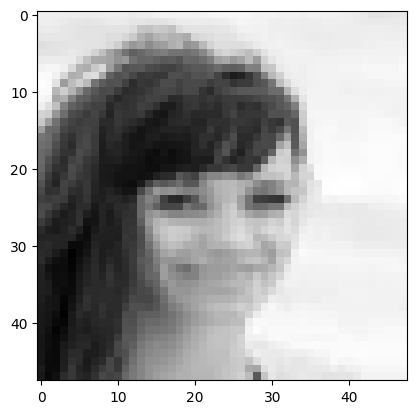

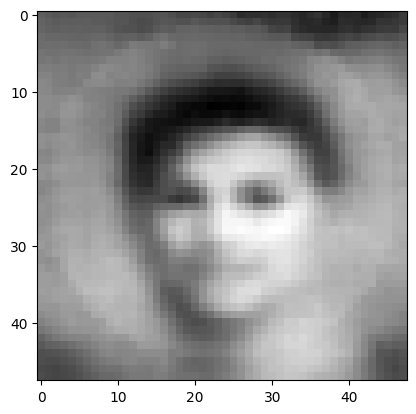

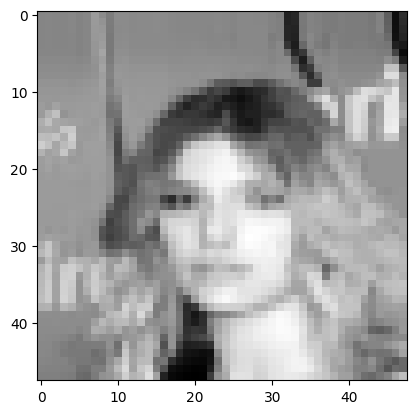

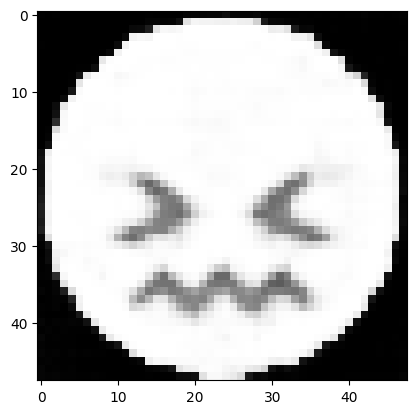

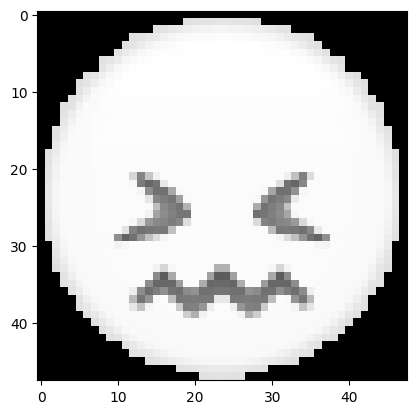

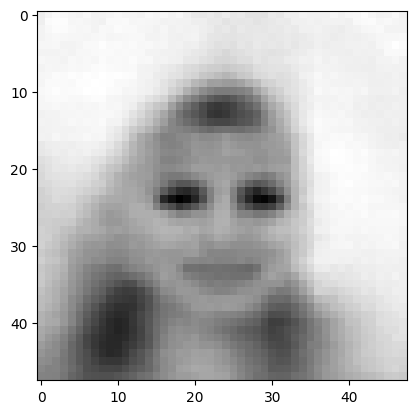

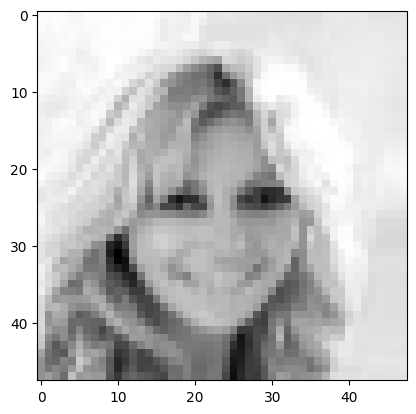

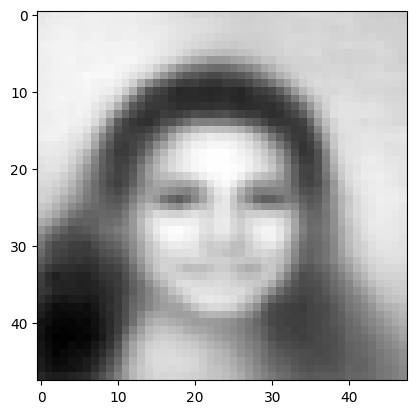

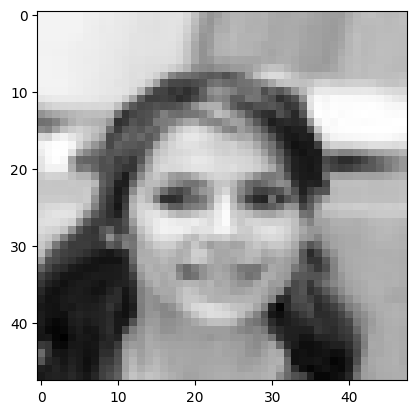

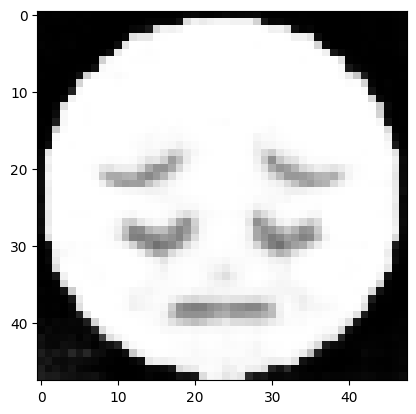

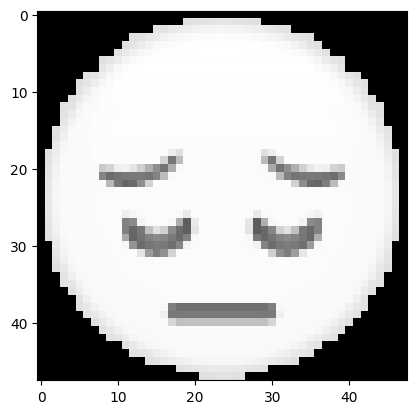

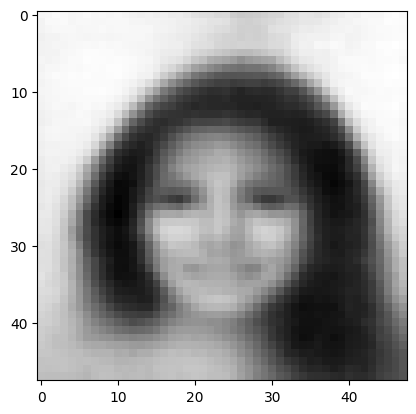

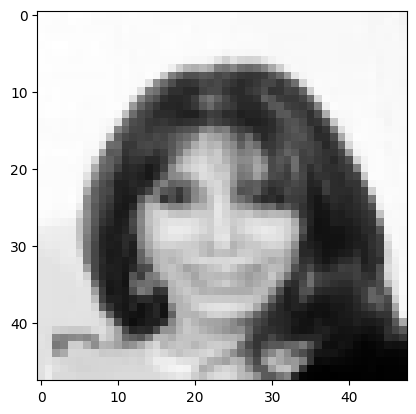

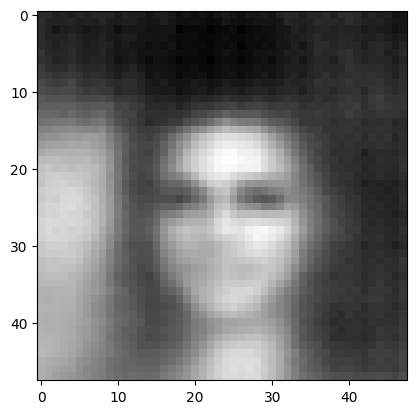

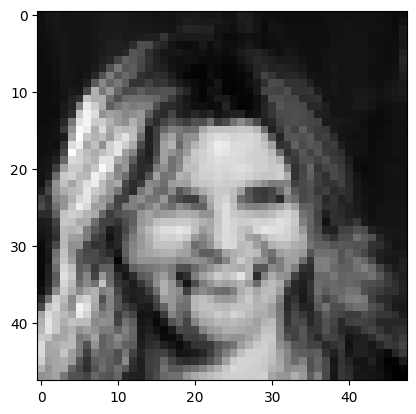

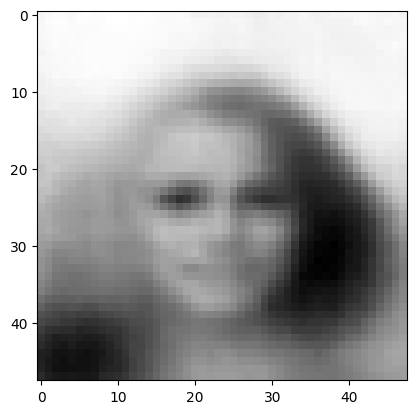

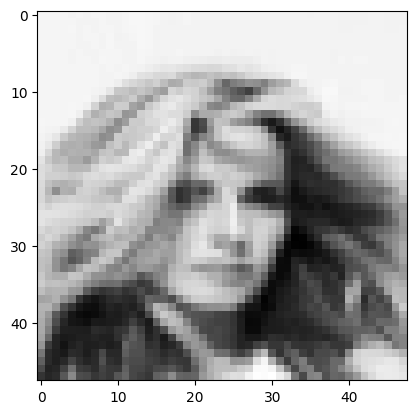

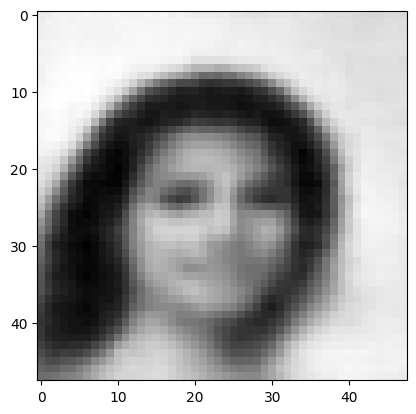

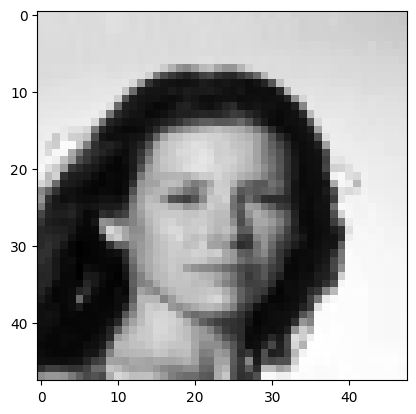

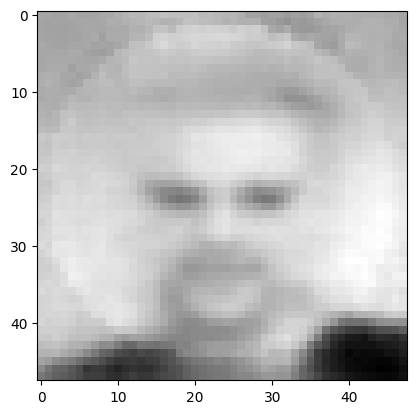

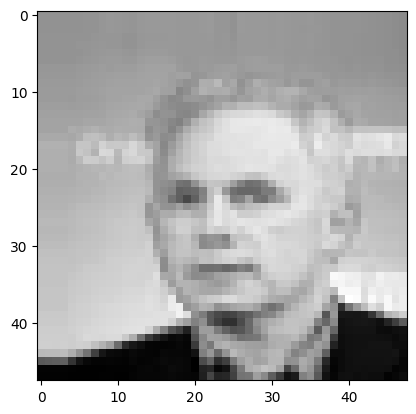

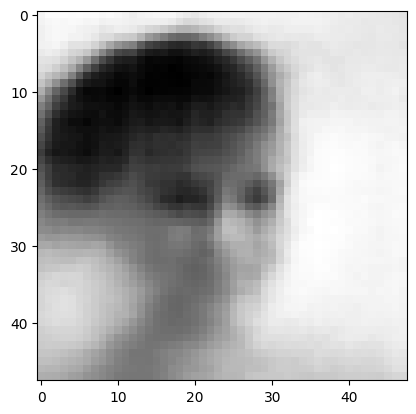

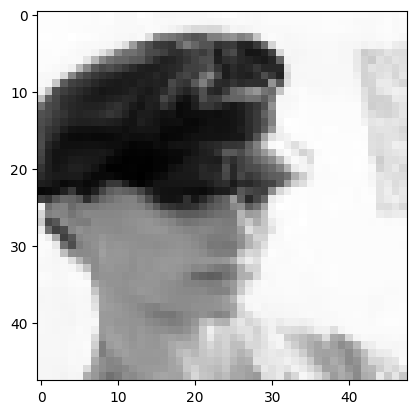

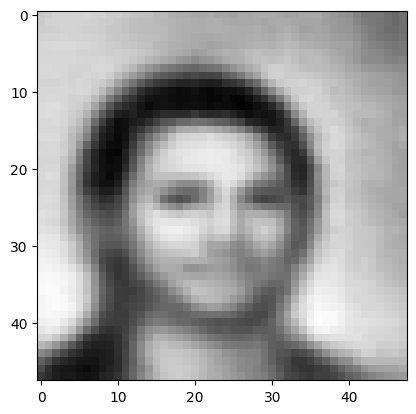

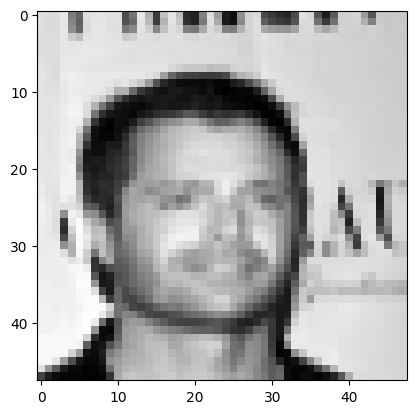

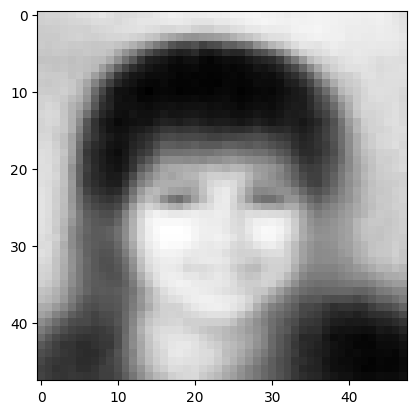

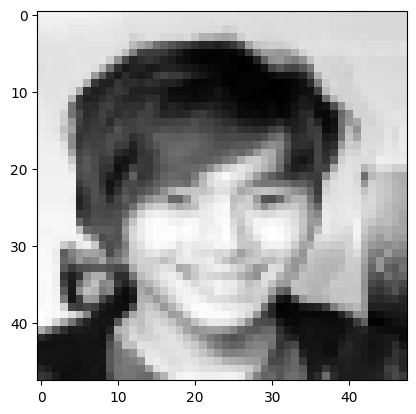

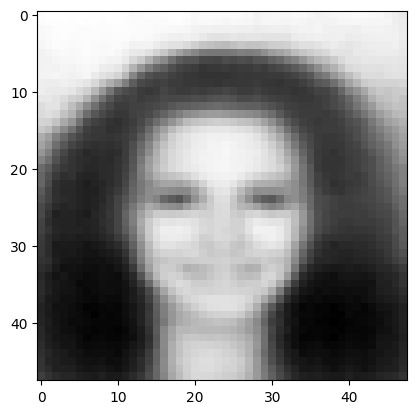

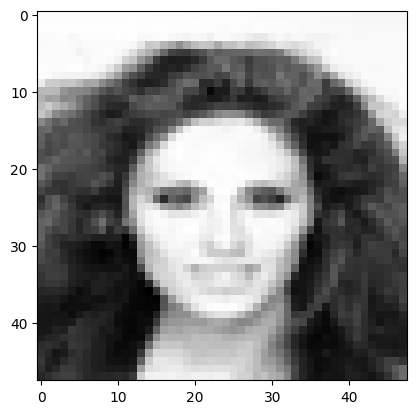

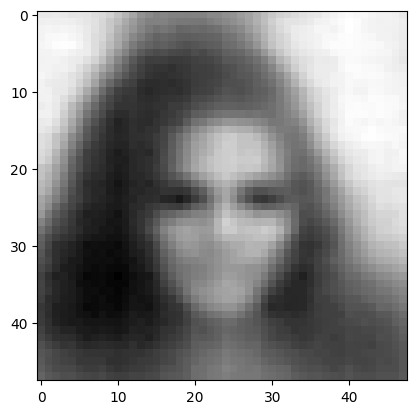

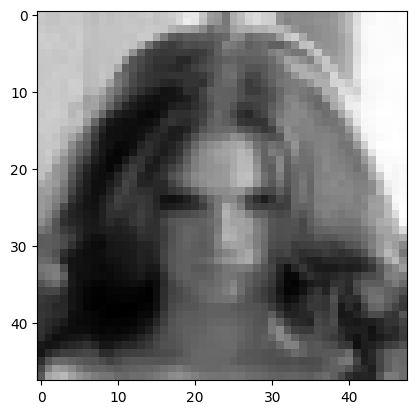

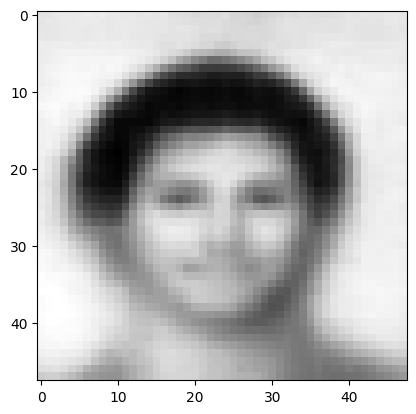

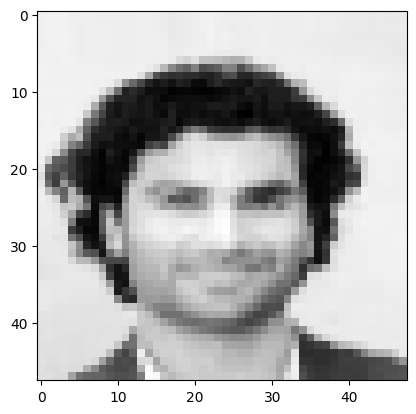

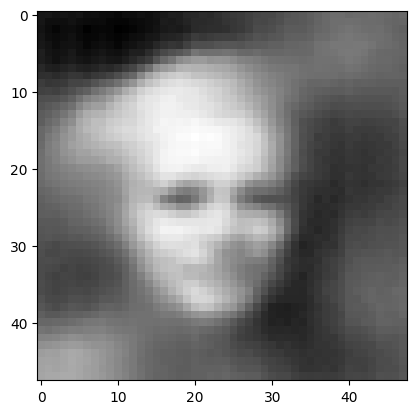

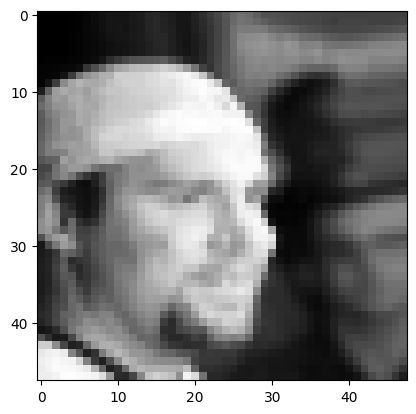

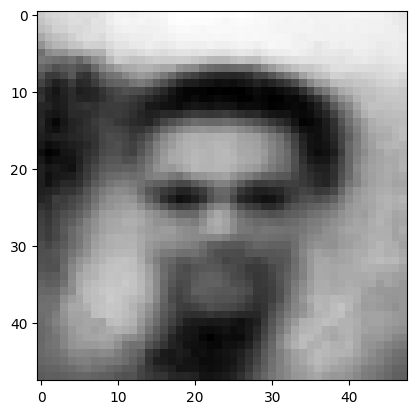

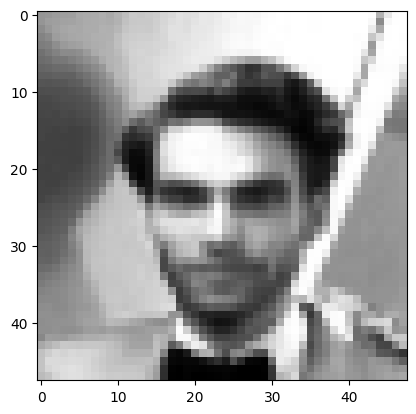

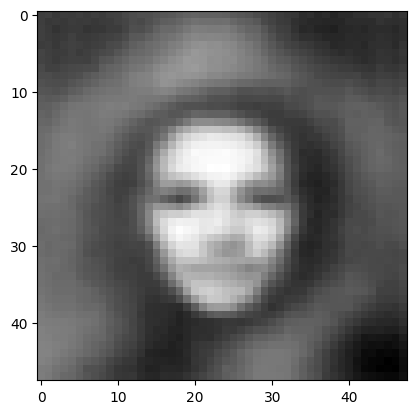

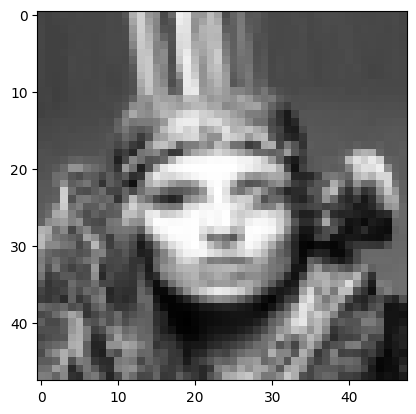

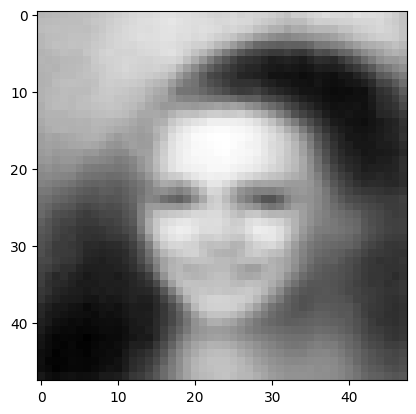

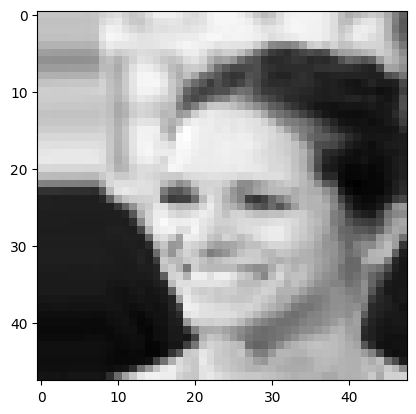

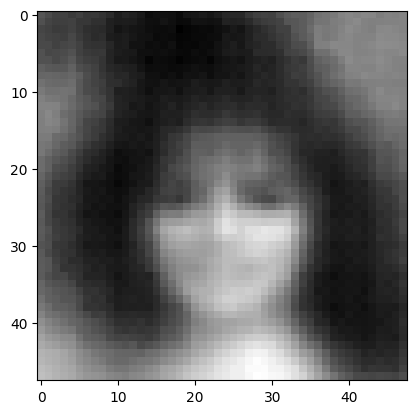

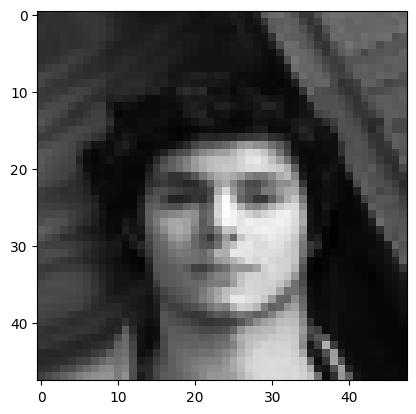

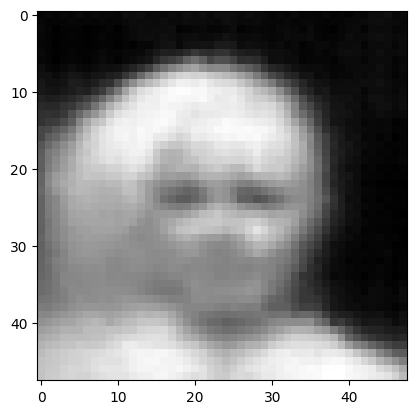

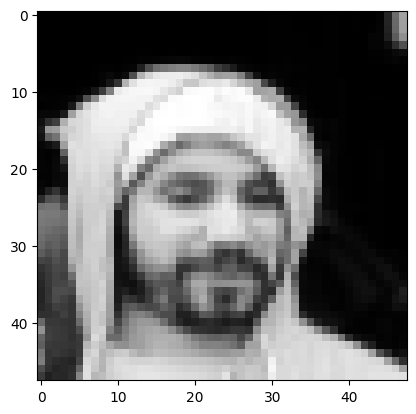

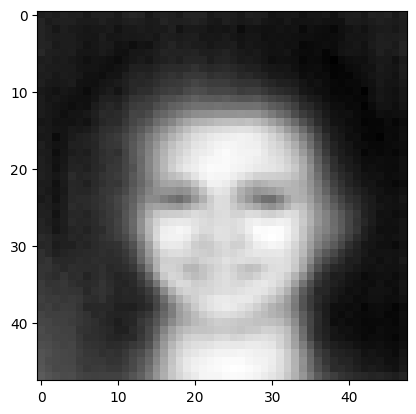

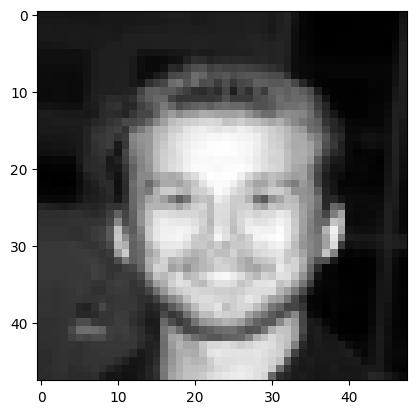

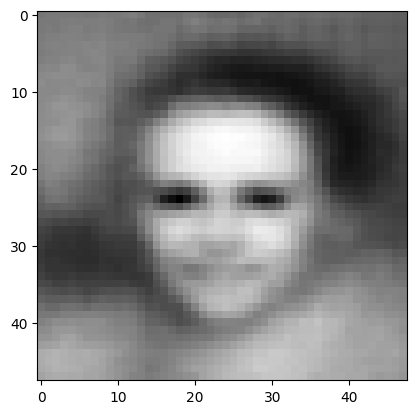

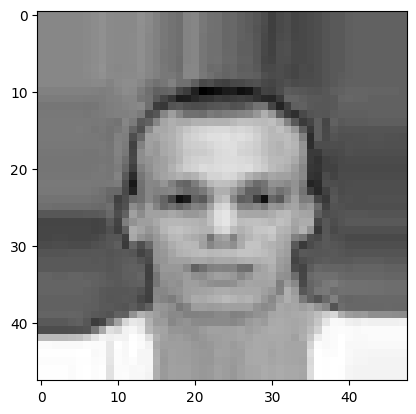

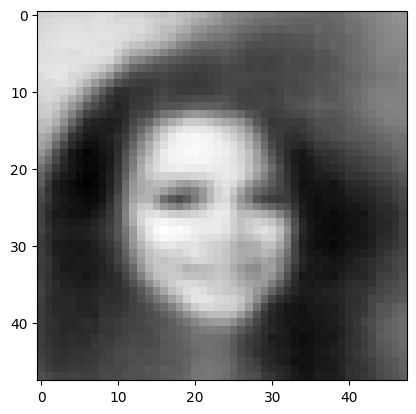

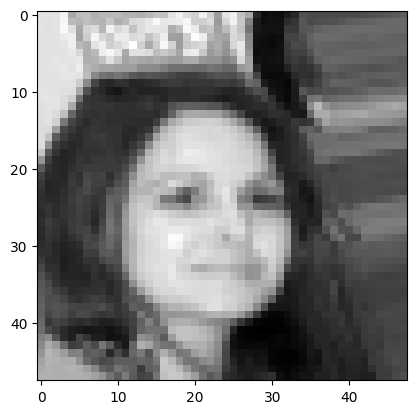

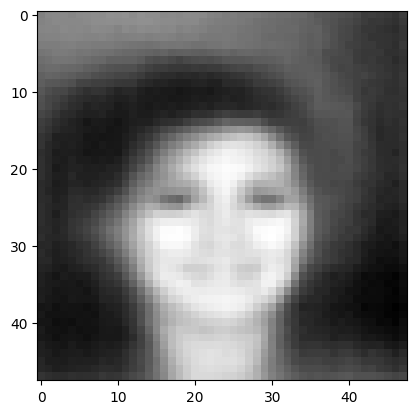

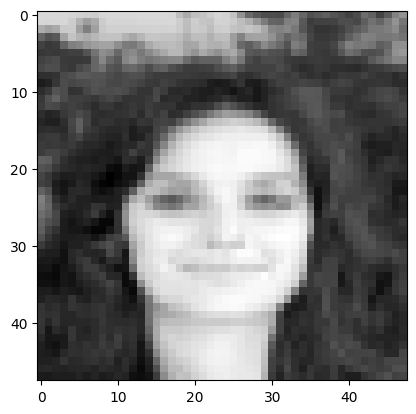

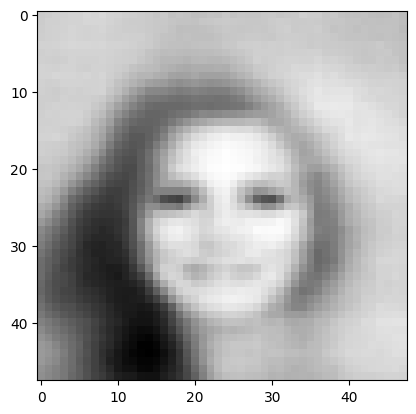

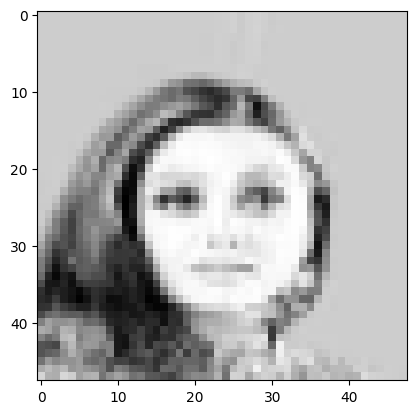

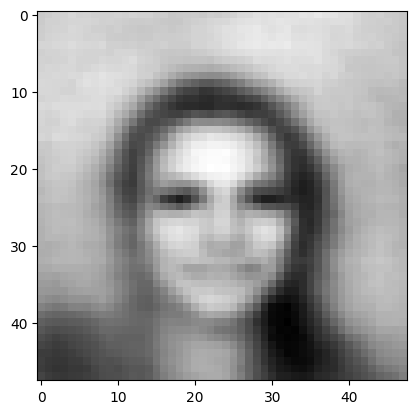

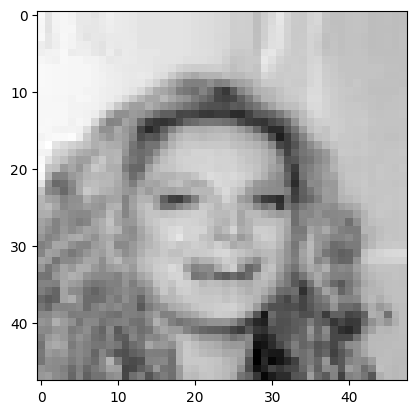

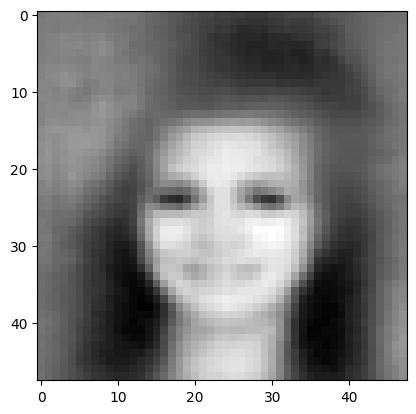

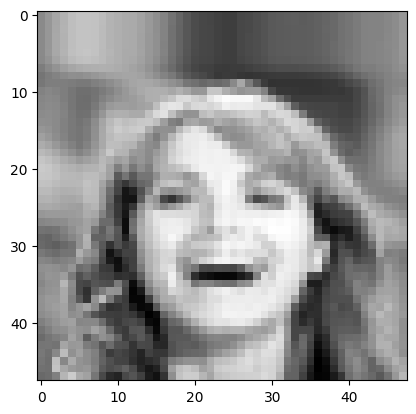

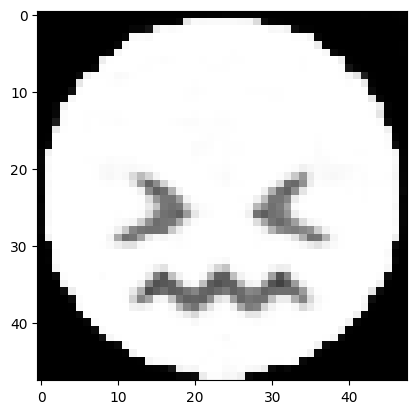

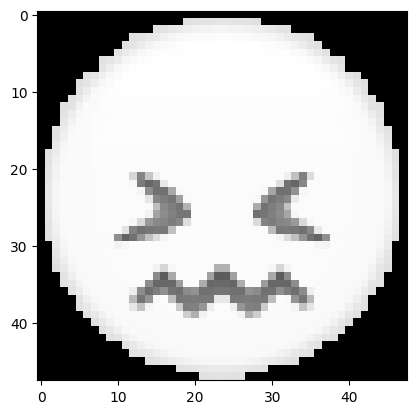

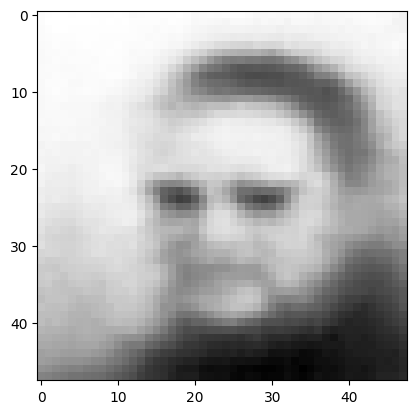

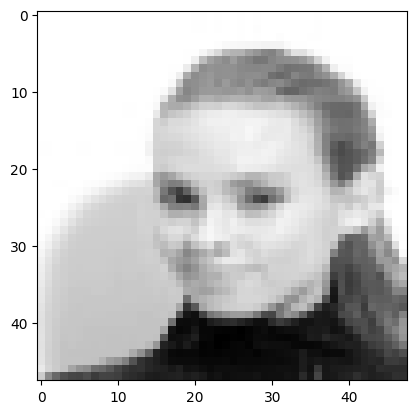

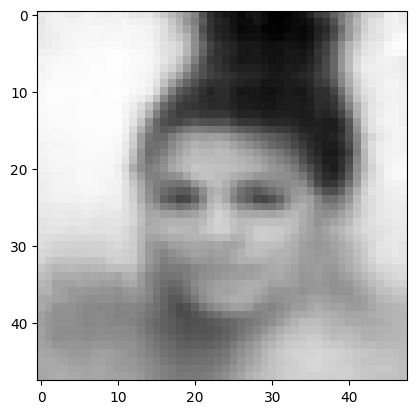

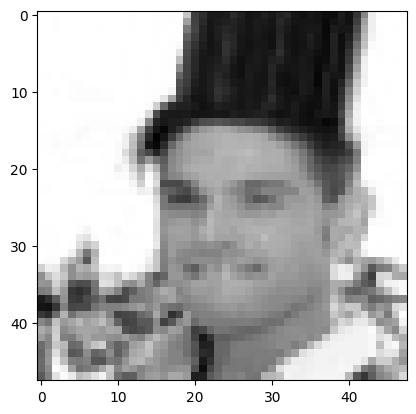

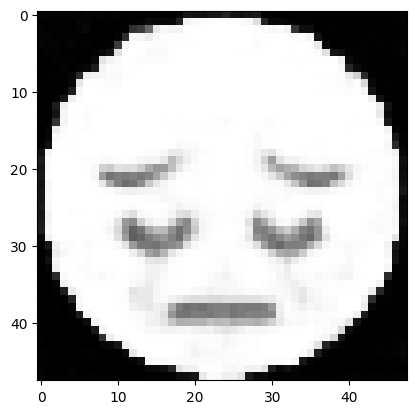

<Figure size 640x480 with 0 Axes>

In [35]:
for i, image in enumerate(val_loader):
  image = image.cuda()
  encoded, z_mean, z_log_var, decoded = vae_model(image)

  input_np = image[0].cpu().detach().numpy()[0]
  decoded_np = decoded[0].cpu().detach().numpy()[0]

  fig = plt.figure()
  plt.imshow(decoded_np, cmap='gray')
  fig2 = plt.figure()
  plt.imshow(input_np, cmap='gray')


In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm

vae_model.eval()

x_dim = 48*48

with torch.no_grad():
  for batch_idx, x in enumerate(tqdm(val_loader)):
    x.cuda()

    x_hat = vae_model(x)

    break

def show_image(x, idx):
  tensor = x[0]  # Extract the first tensor from the tuple
  tensor = tensor.view(256, 48, 48)

  fig = plt.figure()
  plt.imshow(tensor[idx].cpu().numpy(), cmap = "gray")


for i in range(0,1):
  show_image(x, idx=i)
  show_image(x_hat, idx=i)

## Evaluation

In [12]:
def plot_training_batch_loss(batch_loss, num_epochs):
  iterations = range(len(batch_loss))
  plt.plot(iterations, batch_loss)

  plt.title("Batch Loss")
  plt.xlabel("Iterations")
  plt.ylabel("Batch Loss")

  plt.show()

def plot_loss(train_loss, val_loss, num_epochs):
  iterations = range(len(train_loss))
  plt.plot(iterations, train_loss, label='Training Loss')
  plt.plot(iterations, val_loss, label='Validation Loss')

  plt.title("Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  plt.show()

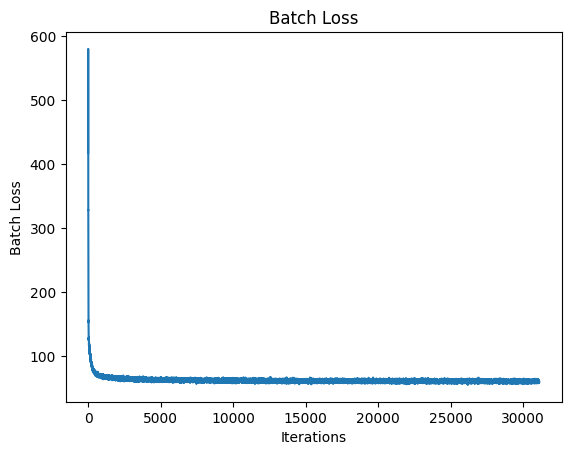

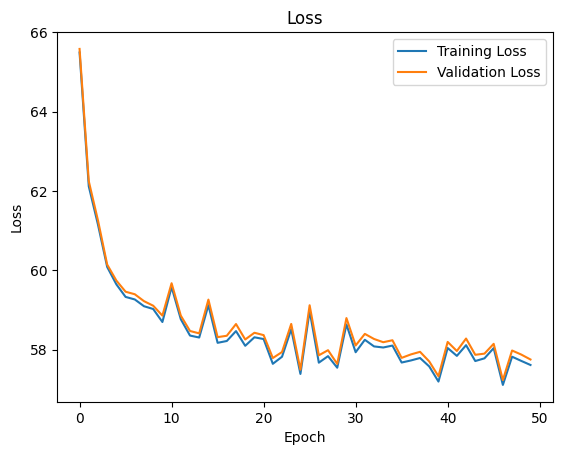

In [13]:
plot_training_batch_loss(batch_loss, NUM_EPOCHS)
plot_loss(train_loss, val_loss, NUM_EPOCHS)

# Emoji Dataset Modification

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

if os.path.exists("/content/All_Emojis_With_Rotations"):
  print(".zip folders already unzipped.")
else:
  !unzip "/content/drive/MyDrive/APS360/Project/All_Emojis_With_Rotations.zip" -d "/content" &> /dev/null

In [ ]:
import os
import shutil

def process_png_files(source_dir, destination_dir):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    png_files = [file for file in os.listdir(source_dir) if file.lower().endswith('.png')]
    for index, png_file in enumerate(png_files):
        src_path = os.path.join(source_dir, png_file)
        dst_file = f'270_{index}.png'
        dst_path = os.path.join(destination_dir, dst_file)
        shutil.copy(src_path, dst_path)
        print(f"Processed: {src_path} -> {dst_path}")

source_directory = "/content/Emoji_270"
destination_directory = "/content/All_Emojis"
process_png_files(source_directory, destination_directory)


In [ ]:
!zip -r /content/All_Emojis.zip /content/All_Emojis

In [ ]:
import os
import shutil
import random

def copy_random_png_files(source_dir, destination_dir, target_count):
    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    source_files = []
    for root, dirs, files in os.walk(source_dir):
        for filename in files:
            if filename.lower().endswith(".png"):
                source_files.append(os.path.join(root, filename))

    random.shuffle(source_files)
    count = 0
    while count < target_count:
        for idx, source_file_path in enumerate(source_files):
            if count >= target_count:
                print(f"Copied {count} images to {destination_dir}.")
                return

            filename = f"{count + 1}.png"
            destination_file_path = os.path.join(destination_dir, filename)
            shutil.copy2(source_file_path, destination_file_path)
            count += 1

source_directory = "/content/All_Emojis_With_Rotations"
destination_directory = "/content/lots_emojis2"
target_count = 25000

copy_random_png_files(source_directory, destination_directory, target_count)


Copied 25000 images to /content/lots_emojis2.


In [ ]:
!zip -r /content/lots_emojis2.zip /content/lots_emojis2

In [ ]:
import os
import shutil

def copy_files_with_unique_names(source_dir, destination_dir, num_copies):
    png_files = [file for file in os.listdir(source_dir) if file.lower().endswith('.png')]

    if not os.path.exists(destination_dir):
        os.makedirs(destination_dir)

    for png_file in png_files:
        for i in range(num_copies):
            unique_name = f"{os.path.splitext(png_file)[0]}_copy_{i + 1}.png"
            source_path = os.path.join(source_dir, png_file)
            destination_path = os.path.join(destination_dir, unique_name)

            shutil.copy2(source_path, destination_path)

source_directory = "/content/output_emojis"
destination_directory = "/content/25k_emojis_6"
num_copies = 4166

copy_files_with_unique_names(source_directory, destination_directory, num_copies)


In [ ]:
!zip -r /content/25k_emojis_6.zip /content/25k_emojis_6

# Baseline Model

In [ ]:
# baseline model - ANN
# torch.manual_seed(10) # set the random seed

class ANN_FER(nn.Module):
    def __init__(self):
        super(ANN_FER, self).__init__()
        self.name = "fer"
        self.layer1 = nn.Linear(1 * 48 * 48, 32)
        self.layer2 = nn.Linear(32, 6)

    def forward(self, x):
        x = x.view(-1, 1 * 48 * 48)  # Reshape input tensor
        x = F.relu(self.layer1(x))  # Pass through layer1 and apply activation
        x = self.layer2(x)
        x = x.squeeze(1)  # Flatten to [batch_size]
        return x

In [ ]:
# training baseline model

# training our fer_net
# instantiating NNs
torch.manual_seed(1)
baseline = ANN_FER()

if use_cuda and torch.cuda.is_available():
  baseline.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')

baseline = ANN_FER()
train_classifier(baseline, train_loader, val_loader, learning_rate=0.01, num_epochs=20)
torch.save(baseline.state_dict(), "baseline.pth")

In [ ]:
print("BASELINE TEST ACCURACY: ", get_accuracy(baseline, test_loader))

In [ ]:
# basic train_net structure
# change loss function, could add batch_size or just define later

def train(model, train_loader, valid_loader, num_epochs=30, learning_rate=0.0001):
    torch.manual_seed(42)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        total_train_loss = 0.0
        for data in train_loader:
            datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
            recon = model(datam)
            loss = criterion(recon, data)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()

        train_acc[epoch] = get_accuracy(model, train_loader)
        train_loss[epoch] = float(total_train_loss) / (len(train_loader))
        val_acc[epoch] = get_accuracy(model, valid_loader)
        val_loss[epoch] = get_loss(model, valid_loader, criterion)

        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)

    # Plotting
    plt.title("Train vs Validation Loss")
    plt.plot(range(1 ,num_epochs+1), train_loss, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(range(1 ,num_epochs+1), train_acc, label="Train")
    plt.plot(range(1 ,num_epochs+1), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
# function returns what emotion prediction the model predicts
# EXAMPLE: getEmotion('content/test_image1.png')

baseline.load_state_dict(torch.load("baseline.pth")) # path to saved baseline model

# emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sadness', 'surprise']

def getEmotion(image_path):
    # load and preprocess the image
    image = Image.open(image_path).convert('L')  # convert to grayscale
    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
    ])
    image = transform(image).unsqueeze(0)  # batch dimension

    # runs the model to make a prediction
    baseline.eval()
    with torch.no_grad():
        output = baseline(image)
        predicted_emotion_index = torch.argmax(output).item()
        predicted_emotion = emotion_labels[predicted_emotion_index]

    return predicted_emotion

In [ ]:
# Code to directly interpolate between two images,
# as part of the baseline model.

# IMPORTS #
import os
import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#Define path to human input image
human_path = '/content/NewFERPLus/happy/fer0019767.png'

#Get emotion from the ANN
emotion = getEmotion(human_path)

#Define the path to the corresponding emoji images
emoji_path = '/content/Emoji-BW-48x48-CULLED/'
emoji_path = emoji_path + emotion

#Get a list of all png files in the corresponding emoji directory
png_files = [file for file in os.listdir(emoji_path) if file.endswith('.png')]

#Initialize the numpy array to hold the emoji
emoji_array = np.zeros((48, 48))

#Check if the directory was valid
if png_files:
    random_file = random.choice(png_files) #Select a random emoji
    file_path = os.path.join(emoji_path, random_file)

    emoji_image = Image.open(file_path).convert("L") #Open image and convert to grayscale
    emoji_array = np.array(emoji_image) #Convert to numpy array
else:
    print('No PNG files found in the directory.')

human_image = Image.open(human_path).convert("L") #Open image and convert to grayscale
human_array = np.array(human_image) #Convert to numpy array

interpolated_array = 0.5 * emoji_array + 0.5 * human_array #Interpolate between the two images
interpolated_image = Image.fromarray(interpolated_array.astype(np.uint8))

emoji_image.save('/content/emoji_image.png')
human_image.save('/content/human_image.png')
interpolated_image.save('/content/interpolated_output.png')

emoji_image.show()
human_image.show()
interpolated_image.show() #Show the interpolated image

# **Integration Section**

## Imports

In [14]:
pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 11.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116932 sha256=521c8b1c55f0d1342bbc394edc808694d08a2fc756d46afccb9fa2a9126b8d82
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [15]:
pip install deepface

In [16]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import random
from deepface import DeepFace
from PIL import Image
import matplotlib.pyplot as plt

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [17]:
# DRIVE IMPORTS

from google.colab import drive
drive.mount('/content/drive')

if os.path.exists("/content/Testing_Images"):
  print(".zip folders already unzipped.")
else:
  print("Unzipping folders.")
  !unzip "/content/drive/MyDrive/APS360/Project/Testing_Images.zip" -d "/content" &> /dev/null
  !unzip "/content/drive/MyDrive/APS360/Project/output_emojis.zip" -d "/content" &> /dev/null

  print("Unzipping folders completed.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Unzipping folders.
Unzipping folders completed.


## Definitions

### Randomness

In [18]:
#Set all random seeds.
RANDOM_SEED = 0
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

### DeepFace

In [19]:
# Function to extract faces from an input image.
# Works on png images saved to disk.

def extract_faces(img_path, output_size=(48,48), scaling_factor=1.2):
  faces_list = DeepFace.extract_faces(img_path, target_size=(48,48), align=True)

  output_list = []

  for i, face in enumerate(faces_list):
    im = Image.open(img_path)

    centre_x = face['facial_area']['x'] + int(face['facial_area']['w']/2)
    centre_y = face['facial_area']['y'] + int(face['facial_area']['h']/2)
    cropped_width = face['facial_area']['w']
    cropped_height = face['facial_area']['h']

    scaled_width_half = int(cropped_width * scaling_factor / 2)
    scaled_height_half = int(cropped_height * scaling_factor / 2)

    left = centre_x - scaled_width_half
    right = centre_x + scaled_width_half
    top = centre_y - scaled_height_half
    bottom = centre_y + scaled_height_half

    im_out = im.crop((left, top, right, bottom))
    im_out = im_out.resize(output_size, Image.ANTIALIAS)
    im_out = im_out.convert('L')

    temp_dict = {
        "cropped_image": im_out,
        "cropped_image_size": im_out.size,
        "input_image_size": im.size,
        "face_centre": (centre_x, centre_y),
        "scaled_width": scaled_width_half * 2,
        "scaled_height": scaled_height_half * 2,
        "ltrb": (left, top, right, bottom)
    }

    output_list.append(temp_dict)
  return output_list

# Function to paste images onto an original picture.

def paste_faces(orig_img_path, face_images_data):
  im = Image.open(orig_img_path)

  for face in face_images_data:
    resized_image = face["cropped_image"].resize((face["scaled_width"], face["scaled_height"]), Image.ANTIALIAS)
    im.paste(resized_image, (face['ltrb'][0],face['ltrb'][1]))
  return im

### Emotion Recognition CNN

In [25]:
# MODEL DEFINITION

# defining our NNs and their respective training functions

# the facial emotion recognition CNN
# input image = 48x48?
class CNN_FER(nn.Module):
    def __init__(self):
        super(CNN_FER, self).__init__()
        self.name = "fer"
        self.conv1 = nn.Conv2d(1, 6, 5) # in_channel, out_channel, kernel_size
        self.pool = nn.MaxPool2d(2, 2) # kernel_size, stride
        self.conv2 = nn.Conv2d(6, 12, 5)
        self.fc1 = nn.Linear(9 * 9 * 12, 64)
        self.fc2 = nn.Linear(64, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 9 * 9 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

#class CNN_FER(nn.Module):
#    def __init__(self):
#        super(CNN_FER, self).__init__()
#        self.name = "fer"
#        self.conv1 = nn.Conv2d(1, 2, 5) # in_channel, out_channel, kernel_size
#        self.pool = nn.MaxPool2d(2, 2) # kernel_size, stride
#        self.conv2 = nn.Conv2d(2, 6, 5)
#        self.fc1 = nn.Linear(9 * 9 * 6, 32)
#        self.fc2 = nn.Linear(32, 6)

#    def forward(self, x):
#        x = self.pool(F.relu(self.conv1(x)))
#        x = self.pool(F.relu(self.conv2(x)))
#        x = x.view(-1, 9 * 9 * 6)
#        x = F.relu(self.fc1(x))
#        x = self.fc2(x)
#        x = x.squeeze(1) # Flatten to [batch_size]
#        return x

# GET EMOTION FROM VECTOR

def get_emotion_from_number(number):
  if number == 0:
    return 'angry'
  elif number == 1:
    return 'disgust'
  elif number == 2:
    return 'fear'
  elif number == 3:
    return 'happy'
  elif number == 4:
    return 'sadness'
  elif number == 5:
    return 'surprise'
  else:
    return 'NON_MATCHING_NUMBER'

### VAE

In [21]:
# MODEL

class Do_View(nn.Module):
  def __init__(self, *args):
    super().__init__()
    self.shape = args
  def forward(self, x):
    return x.view(self.shape)

class Cut_Down(nn.Module):
  def __init__(self, *args):
    super().__init__()
  def forward(self, x):
    return x[:,:, :48, :48]

class VAE_Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
      nn.Conv2d(1, 32, stride=2, kernel_size=3, bias=False, padding=1),
      nn.BatchNorm2d(32),
      nn.LeakyReLU(0.1, inplace=True),
      nn.Dropout2d(0.25),
      # Now size 24x24x32
      nn.Conv2d(32, 64, stride=2, kernel_size=3, bias=False, padding=1),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.1, inplace=True),
      nn.Dropout2d(0.25),
      # Now size is 12x12x64
      nn.Conv2d(64, 64, stride=2, kernel_size=3, bias=False, padding=1),
      nn.BatchNorm2d(64),
      nn.LeakyReLU(0.1, inplace=True),
      nn.Dropout2d(0.25),
      # Now size is 6x6x64
      nn.Flatten(),
      #Now total length is 6x6x64=2304
    )

    self.z_mean = torch.nn.Linear(2304, 200)
    self.z_log_var = torch.nn.Linear(2304, 200)

    self.decoder = nn.Sequential(
        torch.nn.Linear(200,2304),
        Do_View(-1,64,6,6),
        #Now size is 6x6x64
        nn.ConvTranspose2d(64, 64, stride=2, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Dropout2d(0.25),
        #Now size is 13x13x64
        nn.ConvTranspose2d(64, 32, stride=2, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Dropout2d(0.25),
        #Now size is 25x25x32
        nn.ConvTranspose2d(32, 1, stride=2, kernel_size=3, padding=1),
        #Now size is 49x49x1
        Cut_Down(), #1x49x49 -> 1x48x48
        nn.Sigmoid()
    )

  def encoding_fn(self, x):
    x = self.encoder(x)
    z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
    encoded = self.reparameterize(z_mean, z_log_var)
    return encoded

  def reparameterize(self, z_mu, z_log_var):
    eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())
    z = z_mu + eps * torch.exp(z_log_var/2.)
    return z

  def forward(self, x):
    x = self.encoder(x)
    z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
    encoded = self.reparameterize(z_mean, z_log_var)
    decoded = self.decoder(encoded)
    return encoded, z_mean, z_log_var, decoded

  def decoding(self, x):
    decoded = self.decoder(x)
    return decoded


### Get Emoji Path

In [22]:
def get_emoji_path(emotion):
  if emotion == 'angry':
    return '/content/output_emojis/angry.png'
  elif emotion == 'disgust':
    return '/content/output_emojis/disgust.png'
  elif emotion == 'fear':
    return '/content/output_emojis/fear.png'
  elif emotion == 'happy':
    return '/content/output_emojis/happy.png'
  elif emotion == 'sadness':
    return '/content/output_emojis/sadness.png'
  elif emotion == 'surprise':
    return '/content/output_emojis/surprise.png'
  else:
    return ''

### Emojification

In [23]:
#This is just here as a definition
transform_cropped = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

def emojify(input_img_path):
  print("Running emojification algorithm.")
  print("")

  # LOAD AND DISPLAY INPUT IMAGE
  print("Input image:")
  input_img = Image.open(input_img_path).convert("L")
  plt.imshow(input_img, cmap='gray')
  plt.show()
  print("")

  # EXTRACT FACE FROM INPUT IMAGE
  extracted_faces = extract_faces(img_path = input_img_path, scaling_factor = 1.2)
  cropped = extracted_faces[0]['cropped_image'] #This is a Pillow image of the cropped face.
  cropped_tensor = transform_cropped(cropped).unsqueeze(0)

  # GET EMOTION FROM CNN MODEL

  # LOAD THE EMOTION CLASSIFIER MODEL
  !cp "/content/drive/MyDrive/APS360/Project/model_cnn_62" -d "/content" &> /dev/null
  fer_net = CNN_FER()
  fer_net.load_state_dict(torch.load("model_cnn_62"))

  # EVALUATE THE EMOTION
  with torch.no_grad():
    cnn_out = fer_net(cropped_tensor)
  emotion = get_emotion_from_number(torch.argmax(cnn_out, dim=1).item()) #angry, disgust, etc.
  print("Emotion identified as " + emotion + ".")

  # LOAD EMOJI IMAGE
  emoji_path = get_emoji_path(emotion)
  emoji_img = Image.open(emoji_path)
  emoji_tensor = transform_cropped(emoji_img).unsqueeze(0)

  # LOAD THE VAE MODEL
  !cp "/content/drive/MyDrive/APS360/Project/vae_test50.pt" -d "/content" &> /dev/null
  vae_net = VAE_Model()
  vae_net.cuda()
  vae_net.load_state_dict(torch.load("vae_test50.pt"))

  # EVALUATE THE EMBEDDINGS
  with torch.no_grad():
    emoji_tensor = emoji_tensor.cuda()
    cropped_tensor = cropped_tensor.cuda()
    emoji_encoding, _, _, _ = vae_net(emoji_tensor)
    face_encoding, _, _, _ = vae_net(cropped_tensor)

  # INTERPOLATE
  #interpolated_enc = torch.mean(torch.stack([emoji_encoding, face_encoding]), dim=0)
  interpolated_enc = (1-0.65) * emoji_encoding + 0.65 * face_encoding

  # INTERPOLATED IMAGE
  interpolated_out = vae_net.decoding(interpolated_enc)

  # CONVERT TO NUMPY ARRAY
  cropped_np = cropped_tensor[0].cpu().detach().numpy()[0]
  emoji_np = emoji_tensor[0].cpu().detach().numpy()[0]
  interpolated_np = interpolated_out[0].cpu().detach().numpy()[0]

  # PLOT THE INPUT FACE, INPUT EMOJI, AND OUTPUT

  print("")
  print("VAE Model Results:")
  # Create a 1x2 grid of subplots
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))

  # Plot the cropped input image in the first subplot
  axs[0].imshow(cropped_np, cmap='gray')  # Assuming it's a grayscale image
  axs[0].set_title('Input Cropped Image')

  # Plot the corresponding input emoji image in the second subplot
  axs[1].imshow(emoji_np, cmap='gray')  # Assuming it's a grayscale image
  axs[1].set_title('Corresponding Emoji')

  # Plot the output interpolate image in the third subplot
  axs[2].imshow(interpolated_np, cmap='gray')  # Assuming it's a grayscale image
  axs[2].set_title('Interpolated Image')
  plt.show()

  print("")
  print("Final Output Image:")
  scaled_interpolated = (interpolated_np * 255).astype(np.uint8)
  extracted_faces[0]['cropped_image'] = Image.fromarray(scaled_interpolated,  mode='L') #test_emoji_img is a grayscale pillow image
  final_img = paste_faces(orig_img_path = input_img_path, face_images_data = extracted_faces).convert('L')

  plt.imshow(final_img, cmap='gray')
  plt.show()

## Running Code

In [ ]:
emojify("/content/Testing_Images/Testing_1.jpg")

In [ ]:
emojify("/content/Testing_Images/Testing_2.jpg")

In [ ]:
emojify("/content/Testing_Images/Testing_3.jpg")